<h1> <strong> <center> Deep Learning Project -- Squeeze and Excitation Network: SEResNet50 </center> </strong> </h1>

<h4> <strong>  1)  Library Imports </strong> </h4>

In [1]:
# System and File Utilities
from pathlib import Path
import os
import random
from collections import Counter

# Image Handling and Visualization
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Dataset Splitting and Evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# PyTorch Core and Utilities
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# Model and Training Tools
import timm  
from tqdm import tqdm

# Data Augmentation and Transformations
from torchvision import transforms

# Grad-CAM
!pip install grad-cam
from pytorch_grad_cam import GradCAMPlusPlus
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<h4> <strong>  2)  Dataset Collection and Labeling: </strong> </h4>

- defines TB and Normal image sources from multiple datasets
- applies basic resizing and tensor transformations 
- constructs a unified labeled dataset by collecting all valid image files into Final_Dataset.

In [3]:
sources = {
    "Dataset 2 - TB":  (Path("/content/drive/MyDrive/Dataset2/Tuberculosis"), 1),
    "Dataset 3 - TB":  (Path("/content/drive/MyDrive/Dataset3/imgs/tb"), 1),
    "Dataset 4 - TB":  (Path("/content/drive/MyDrive/Dataset4/TURBERCULOSIS"), 1),

    # "Dataset 2 - Normal":  (Path("/content/drive/MyDrive/Dataset2/Normal"), 0),
    "Dataset 3 - Normal":  (Path("/content/drive/MyDrive/Dataset3/imgs/health"), 0),
    # "Dataset 4 - Normal":  (Path("/content/drive/MyDrive/Dataset4/NORMAL"), 0),
}

Final_Dataset = []

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

for label_name, (path, label) in sources.items():
    for img_file in path.glob("*"):
        if img_file.suffix.lower() in [".jpg", ".jpeg", ".png"]:
            Final_Dataset.append((img_file, label))


In [4]:
print(f"\n Total images in Final_Dataset: {len(Final_Dataset)}")
label_counts = Counter([label for _, label in Final_Dataset])
print(f"TB count: {label_counts[1]}, Normal count: {label_counts[0]}")


 Total images in Final_Dataset: 6000
TB count: 2200, Normal count: 3800


<h4> <strong>  3)  Dataset Collection and Labeling: </strong> </h4>

- Shuffles the complete dataset and selects a subset based on the specified percentage to create a smaller working dataset.

In [5]:
x_percent = 1.00
random.shuffle(Final_Dataset)
subset_size = int(len(Final_Dataset) * x_percent)
Small_Dataset = Final_Dataset[:subset_size]

In [6]:
print(f"\n Total images in Small_Dataset ({x_percent * 100}%): {len(Small_Dataset)}")
label_counts = Counter([label for _, label in Small_Dataset])
print(f"TB count: {label_counts[1]}, Normal count: {label_counts[0]}")


 Total images in Small_Dataset (100.0%): 6000
TB count: 2200, Normal count: 3800


<h4> <strong>  4)  Dataset Splitting: </strong> </h4>

- splits the dataset into training (70%), validation (15%), and test (15%) sets

In [7]:
train, temp = train_test_split(Small_Dataset, test_size=0.30, random_state=42)
val, test = train_test_split(temp, test_size=0.50, random_state=42)

In [8]:
def print_split_stats(name, dataset):
    labels = [label for _, label in dataset]
    count = Counter(labels)
    print(f" {name} set: {len(dataset)} images → TB: {count[1]}, Normal: {count[0]}")

print()
print_split_stats("Train", train)
print_split_stats("Validation", val)
print_split_stats("Test", test)


 Train set: 4200 images → TB: 1534, Normal: 2666
 Validation set: 900 images → TB: 356, Normal: 544
 Test set: 900 images → TB: 310, Normal: 590


<h4> <strong>  5) DataLoaders Setup: </strong> </h4>

- defines a custom ChestXrayDataset class to load and transform images with labels
- initializes PyTorch DataLoaders for training, validation, and test sets with a batch size of 8

In [9]:
class ChestXrayDataset(Dataset):
    def __init__(self, data, transform):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert("RGB")
        image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [10]:
batch_size = 8
train_loader = DataLoader(ChestXrayDataset(train, transform), batch_size=batch_size, shuffle=True)
val_loader = DataLoader(ChestXrayDataset(val, transform), batch_size=batch_size)
test_loader = DataLoader(ChestXrayDataset(test, transform), batch_size=batch_size)

In [ ]:
pip install timm

<h4> <strong>  6) Model Definition and Setup: </strong> </h4>

- defines a binary classifier using a pretrained SEResNet50 model 
- initializes the model, loss function, and optimizer

In [12]:
class SEResNet50Binary(nn.Module):
    def __init__(self):
        super(SEResNet50Binary, self).__init__()
        self.base = timm.create_model('seresnet50', pretrained=True)
        self.base.fc = nn.Linear(self.base.fc.in_features, 2)

    def forward(self, x):
        return self.base(x)

model = SEResNet50Binary().cuda()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

<h4> <strong>  7) Model Training: </strong> </h4>

- defines a training function for the SEResNet50 model
- plots the loss curves to visualize model performance

In [14]:
def train_model(model, train_loader, val_loader, epochs=5):
    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False)

        for images, labels in progress_bar:
            images, labels = images.cuda(), labels.cuda()
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.cuda(), labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {avg_train_loss:.4f} - Val Loss: {avg_val_loss:.4f}")

    return train_losses, val_losses

Epoch 1/5 - Train Loss: 0.1858 - Val Loss: 0.0914


Epoch 2/5 - Train Loss: 0.0454 - Val Loss: 0.0348


Epoch 3/5 - Train Loss: 0.0222 - Val Loss: 0.0244


Epoch 4/5 - Train Loss: 0.0199 - Val Loss: 0.0449


Epoch 5/5 - Train Loss: 0.0111 - Val Loss: 0.0167


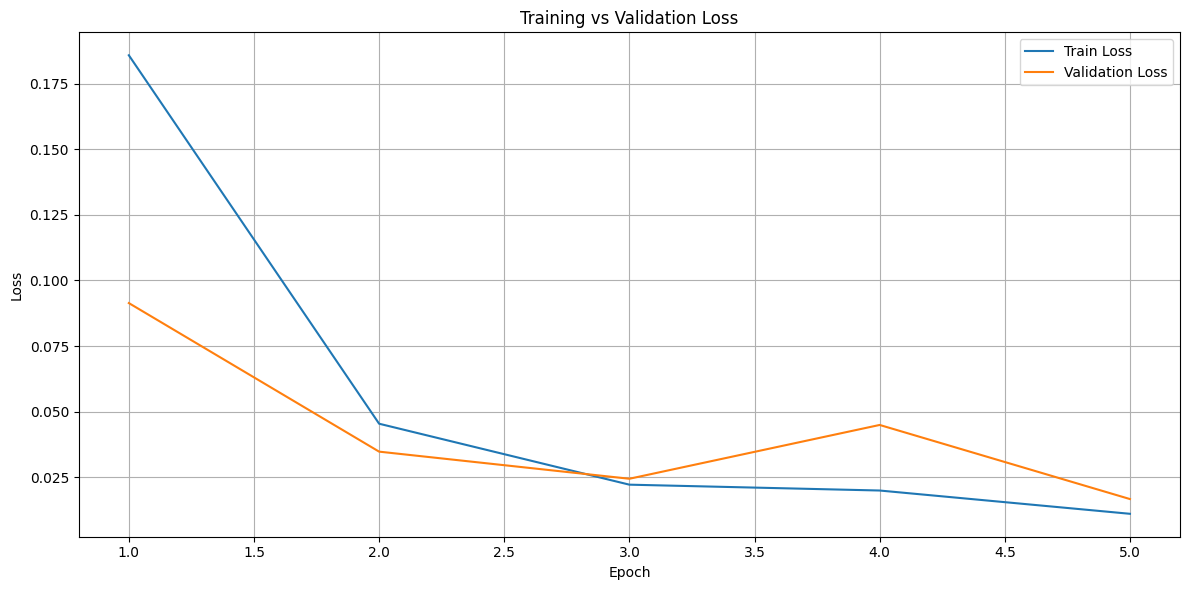

In [15]:
epochs = 5
train_losses, val_losses = train_model(model, train_loader, val_loader, epochs=epochs)

plt.figure(figsize=(12, 6))
plt.plot(range(1, epochs + 1), train_losses, label="Train Loss")
plt.plot(range(1, epochs + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
torch.save(model.state_dict(), "SEResNet50.pth")
print("Model saved")

Model saved


<h4> <strong>  8) Model Evaluation on Test Set: </strong> </h4>

 - evaluates the trained model on the test set
 - prints classification metrics (precision, recall, F1-score)
 - displays a confusion matrix heatmap to visualize prediction

In [17]:
model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

              precision    recall  f1-score   support

      Normal       0.99      0.99      0.99       590
          TB       0.99      0.98      0.99       310

    accuracy                           0.99       900
   macro avg       0.99      0.99      0.99       900
weighted avg       0.99      0.99      0.99       900



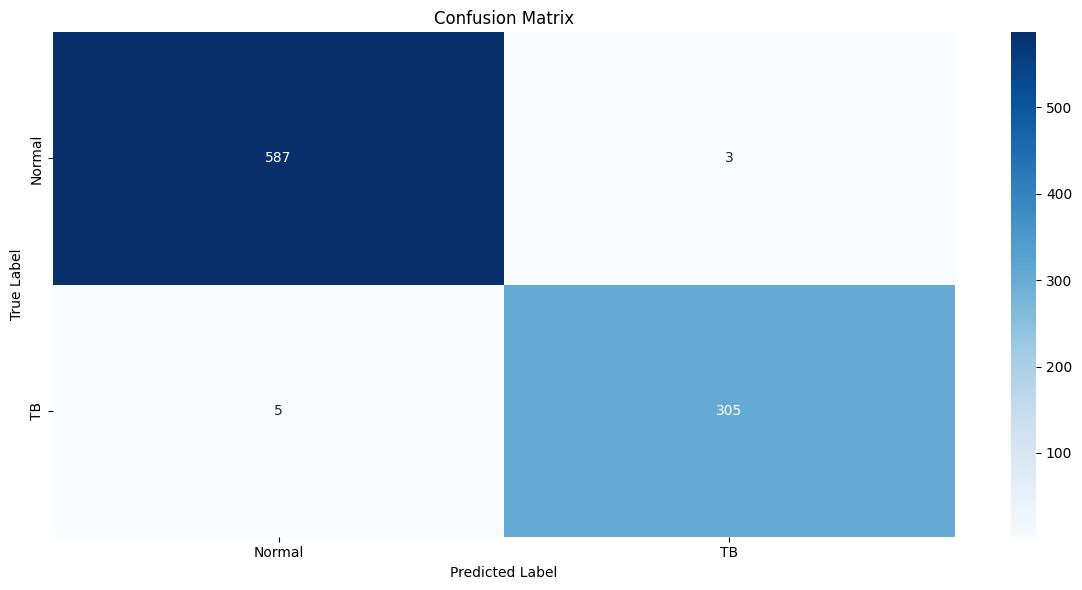

In [18]:
print(classification_report(y_true, y_pred, target_names=["Normal", "TB"]))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "TB"], yticklabels=["Normal", "TB"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [ ]:
!pip install grad-cam

<h4> <strong>  9) GradCAM++ Visualization:</strong> </h4>

- uses GradCAM++ to highlight image regions influencing the model’s predictions
- for a few test samples, it visualizes the original input alongside the corresponding GradCAM++ heatmap to interpret the model’s focus areas

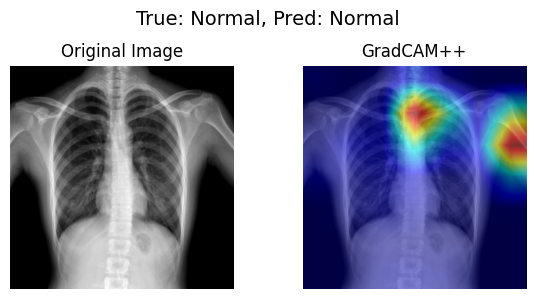

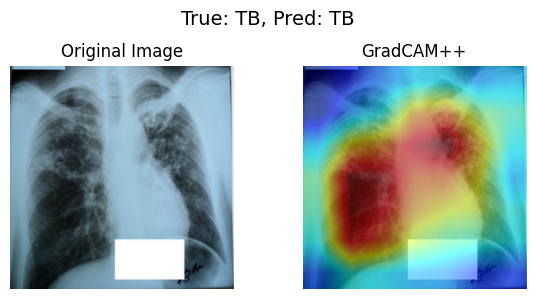

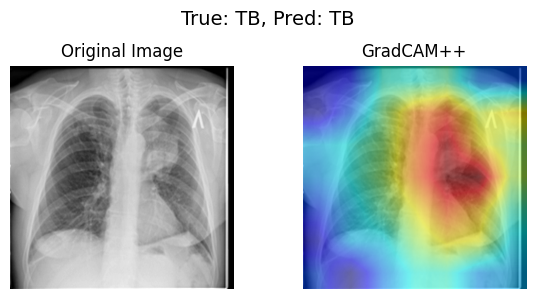

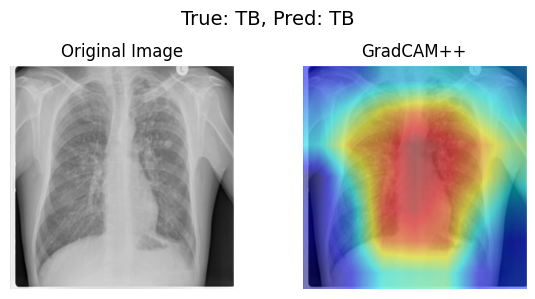

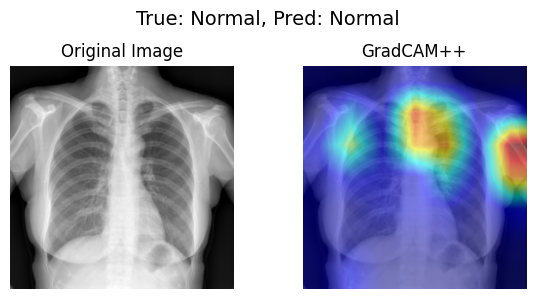

In [20]:
target_layers = [model.base.layer4[-1]]

cam = GradCAMPlusPlus(model=model, target_layers=target_layers)

def visualize_gradcam(dataset, num_images=5):
    model.eval()
    shown = 0
    for i in range(len(dataset)):
        img_tensor, label = dataset[i]
        input_tensor = img_tensor.unsqueeze(0)

        if torch.cuda.is_available():
            input_tensor = input_tensor.cuda()

        rgb_img = img_tensor.permute(1, 2, 0).numpy()
        rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

        outputs = model(input_tensor)
        pred_class = outputs.argmax().item()

        grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])
        grayscale_cam = grayscale_cam[0]

        cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        plt.figure(figsize=(6, 3))
        plt.suptitle(f"True: {'TB' if label==1 else 'Normal'}, Pred: {'TB' if pred_class==1 else 'Normal'}", fontsize=14)

        plt.subplot(1, 2, 1)
        plt.imshow(rgb_img)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(cam_image)
        plt.title("GradCAM++")
        plt.axis("off")

        plt.tight_layout()
        plt.show()

        shown += 1
        if shown >= num_images:
            break

visualize_gradcam(ChestXrayDataset(test, transform), num_images=5)